# load libraries

In [1]:
import sys
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import nibabel as nib
import pandas as pd
import pickle 
from scipy.stats import zscore
import numpy as np
from sklearn.model_selection import KFold
from scipy.stats import pearsonr, binomtest
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon
import h5py
import numpy as np
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns

In [2]:
import logging
import time
import psutil

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


In [3]:
allRuns = [ 'test1_901', 'test2_1101', 'test3_1301', 'test4_1501', 'test5_1701', 'test6_1901', 'test7_2101', 'test8_2301']
nnodes = 59412
nregions = 360
target_parcels = list(range(1,361)) 
target_networks = list(range(1,13))
nnetworks = 12
relevantConds = ['Practice_Cong_NEXT','Practice_Incong_NEXT', 'Novel_Cong_NEXT', 'Novel_Incong_NEXT']

networkmappings = {'vis1':1, 'vis2':2, 'smn':3,'con':4, 'dan':5,'lan':6,'fpn':7,'aud':8, 'dmn':9, 
                   'pmulti':10, 'vmm':11, 'ora':12}  

In [4]:
subjNums = [ 'sub-3', 'sub-4', 'sub-5', 'sub-6', 'sub-7', 'sub-8', 'sub-10', 
         'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20',
           'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-28', 'sub-29', 'sub-30',
          'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40']

In [5]:
sys.path.append('/projects/f_mc1689_1/MeiranNext/docs/scripts/ArunScripts/ActflowTesting/')


In [6]:
actual_data_dir = '/projects/f_mc1689_1/MeiranNext/data/results/ArunResults/ActualBetasParcelwiseH5/'
actual_suffix = '_actualBetas.h5' 

pred_data_dir = '/projects/f_mc1689_1/MeiranNext/data/results/ArunResults/ActivationPermTestFoundIV/'
pred_suffix = '_PermPredBetas.h5'

In [7]:
networkpartition_dir = '/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/dependencies/ColeAnticevicNetPartition/'
networkdef = np.loadtxt(networkpartition_dir + 'cortex_parcel_network_assignments.txt') #1 based 

dlabelfile = '/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii'
dlabels = np.squeeze(nib.load(dlabelfile).get_fdata()) # whole brain, 91282 vertices, 1 based not 0 based
dlabels = dlabels[:nnodes]


vertex_networks = np.zeros(dlabels.shape, dtype=int)
for i in range(nregions):
    parcel_indices = np.where(dlabels == (i + 1))  
    vertex_networks[parcel_indices] = networkdef[i]

In [8]:
def load_and_print_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        return data

# load actual betas

In [9]:
def LoadActualBetas(subj, input_network):
    ActualActivationVecLeft = []
    ActualActivationVecRight = []

    h5_path = actual_data_dir + subj + actual_suffix

    try:
        with h5py.File(h5_path, 'r') as h5f:
            for run in allRuns:
                if run not in h5f:
                    # logging.warning(f"Run {run} missing for {subj}")
                    continue

                for miniblock_key in h5f[run]:
                    mb = h5f[run][miniblock_key]
                    
                    # Skip miniblocks with no motor_response field
                    if 'motor_response' not in mb:
                        continue
                    
                    conditions = [c.decode('utf-8') for c in mb['condition']]
                    betas = mb['betas'][:]
                    
                    motor_resp = [r.decode('utf-8') for r in mb['motor_response']] 

                    for i, cond in enumerate(conditions):
                        if 'GO' in cond:
                            goBetas = betas[i].astype(np.float32, copy=False)
                            button = motor_resp[i]

                            if goBetas.shape[0] != len(networkdef):
                                raise ValueError("Mismatch between GOBetas and networkdef dimensions.")

                            input_mask = (networkdef == input_network)

                            if button == 'left':
                                actVectLeft = goBetas[input_mask]
                                if actVectLeft.size > 0:
                                    ActualActivationVecLeft.append(actVectLeft)

                            elif button == 'right':
                                actVectRight = goBetas[input_mask]
                                if actVectRight.size > 0:
                                    ActualActivationVecRight.append(actVectRight)
    except Exception as e:
        logging.error(f"Failed to process subject {subj} in LoadTemplateActual: {e}")

    if ActualActivationVecLeft:
        ActualActivationVecLeft = np.vstack(ActualActivationVecLeft)
    else:
        ActualActivationVecLeft = None

    if ActualActivationVecRight:
        ActualActivationVecRight = np.vstack(ActualActivationVecRight)
    else:
        ActualActivationVecRight = None

    return ActualActivationVecLeft, ActualActivationVecRight


# load permuted betas

In [10]:
def loadPermutedBetas(subj, iter, input_network):
    pred_path = os.path.join(pred_data_dir, subj, f"{subj}_PermPredBetas.h5")
    actual_path = os.path.join(actual_data_dir, subj + actual_suffix)
    
    try:
        with h5py.File(pred_path, 'r') as f:
            pred_betas = f['PermutedBetas'][:, :, iter]  # shape: (nTrials, nNodes)

        motor_responses = []
        with h5py.File(actual_path, 'r') as f_actual:
            for run in allRuns:
                if run not in f_actual: continue
                for miniblock_key in f_actual[run]:
                    mb = f_actual[run][miniblock_key]
                    
                    # Skip miniblocks with no motor_response field
                    if 'motor_response' not in mb:
                        continue
                        
                    conditions = [c.decode('utf-8') for c in mb['condition']]
                    motor_resp = [r.decode('utf-8') for r in mb['motor_response']]
                    for cond, resp in zip(conditions, motor_resp):
                        if 'GO' in cond:
                            motor_responses.append(resp)

        input_mask = (networkdef == input_network)
        left, right = [], []

        for i, resp in enumerate(motor_responses):
            beta = pred_betas[i, input_mask]
            if resp == 'left':
                left.append(beta)
            elif resp == 'right':
                right.append(beta)

        return np.array(left), np.array(right)
    except Exception as e:
        # logging.error(f"Error loading permuted betas for {subj}, iter {iter}: {e}")
        return None, None


# load non permuted betas

In [11]:
def loadNonPermutedBetas(subj, input_network):
    pred_path = os.path.join(pred_data_dir, subj, f"{subj}_PermPredBetas.h5")
    actual_path = os.path.join(actual_data_dir, subj + actual_suffix)

    try:
        with h5py.File(pred_path, 'r') as f:
            pred_betas = f['NonPermutedBetas'][:]  # shape: (nTrials, nNodes)

        motor_responses = []
        with h5py.File(actual_path, 'r') as f_actual:
            for run in allRuns:
                if run not in f_actual:
                    continue
                for miniblock_key in f_actual[run]:
                    mb = f_actual[run][miniblock_key]

                    # Skip miniblocks with no motor_response field
                    if 'motor_response' not in mb:
                        continue

                    conditions = [c.decode('utf-8') for c in mb['condition']]
                    motor_resp = [r.decode('utf-8') for r in mb['motor_response']]

                    for cond, resp in zip(conditions, motor_resp):
                        if 'GO' in cond:
                            motor_responses.append(resp)

        # Confirm the counts match
        if len(motor_responses) != pred_betas.shape[0]:
            raise ValueError(f"[{subj}] Mismatch: {len(motor_responses)} responses vs {pred_betas.shape[0]} predicted betas")

        input_mask = (networkdef == input_network)
        left, right = [], []

        for i, resp in enumerate(motor_responses):
            beta = pred_betas[i, input_mask]
            if resp == 'left':
                left.append(beta)
            elif resp == 'right':
                right.append(beta)

        return np.array(left), np.array(right)

    except Exception as e:
        # logging.error(f"Error loading non-permuted betas for {subj}: {e}")
        return None, None


# Non permuted accuracies 

In [12]:
def CVcorrNonPermuted(subj, input_network):
    actual_left, actual_right = LoadActualBetas(subj, input_network)
    pred_left, pred_right = loadNonPermutedBetas(subj, input_network)
    
    if actual_left is None or actual_right is None or pred_left is None or pred_right is None:
        return np.nan

    X_actual = np.concatenate((actual_left, actual_right), axis=0)
    X_pred = np.concatenate((pred_left, pred_right), axis=0)
    y = np.array(['L'] * len(actual_left) + ['R'] * len(actual_right))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, test_idx in kf.split(X_actual):
        X_train, y_train = X_actual[train_idx], y[train_idx]
        X_test, y_test = X_pred[test_idx], y[test_idx]

        template_left = X_train[y_train == 'L'].mean(axis=0)
        template_right = X_train[y_train == 'R'].mean(axis=0)

        decode = []
        for x in X_test:
            r_left = np.corrcoef(x, template_left)[0, 1]
            r_right = np.corrcoef(x, template_right)[0, 1]
            decode.append('L' if r_left > r_right else 'R')

        acc = np.mean(np.array(decode) == y_test)
        cv_scores.append(acc)

    return np.mean(cv_scores)


In [13]:
from joblib import Parallel, delayed

def run_nonpermuted_for_subj(subj):
    return [
        CVcorrNonPermuted(subj, network_id)
        for network_id in networkmappings.values()
    ]

non_permuted_pred_accuracy = Parallel(n_jobs=-1)(
    delayed(run_nonpermuted_for_subj)(subj) for subj in tqdm(subjNums)
)
non_permuted_pred_accuracy = np.array(non_permuted_pred_accuracy)  # shape: (nSubjs, nNetworks)


100%|██████████| 36/36 [00:00<00:00, 159.05it/s]


# Permuted accuracies

In [19]:
def CVcorrPermuted(subj, input_network, iter):
    actual_left, actual_right = LoadActualBetas(subj, input_network)
    pred_left, pred_right = loadPermutedBetas(subj, iter, input_network)
    
    if actual_left is None or actual_right is None or pred_left is None or pred_right is None:
        return np.nan

    X_actual = np.concatenate((actual_left, actual_right), axis=0)
    X_pred = np.concatenate((pred_left, pred_right), axis=0)
    y = np.array(['L'] * len(actual_left) + ['R'] * len(actual_right))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, test_idx in kf.split(X_actual):
        X_train, y_train = X_actual[train_idx], y[train_idx]
        X_test, y_test = X_pred[test_idx], y[test_idx]

        template_left = X_train[y_train == 'L'].mean(axis=0)
        template_right = X_train[y_train == 'R'].mean(axis=0)

        decode = []
        for x in X_test:
            r_left = np.corrcoef(x, template_left)[0, 1]
            r_right = np.corrcoef(x, template_right)[0, 1]
            decode.append('L' if r_left > r_right else 'R')

        acc = np.mean(np.array(decode) == y_test)
        cv_scores.append(acc)

    return np.mean(cv_scores)


In [20]:
nPerms = 1000


def run_permuted_single(subj, subj_idx, net_id, net_idx, iter):
    acc = CVcorrPermuted(subj, net_id, iter)
    return (subj_idx, net_idx, iter, acc)

jobs = []

for subj_idx, subj in enumerate(subjNums):
    for net_idx, (net_name, net_id) in enumerate(networkmappings.items()):
        for i in range(nPerms):
            jobs.append((subj, subj_idx, net_id, net_idx, i))

results = Parallel(n_jobs=-1)(
    delayed(run_permuted_single)(*job) for job in tqdm(jobs)
)

# Now populate final array
permuted_pred_accuracies = np.zeros((len(subjNums), len(networkmappings), nPerms))

for subj_idx, net_idx, i, acc in results:
    permuted_pred_accuracies[subj_idx, net_idx, i] = acc


100%|██████████| 432000/432000 [1:29:25<00:00, 80.51it/s]


# statistical testing

In [14]:
non_permuted_pred_accuracy.shape  

(36, 12)

In [15]:
np.isnan(non_permuted_pred_accuracy).sum()

0

In [ ]:
non_permuted_pred_accuracy[:, 0]

In [16]:
nnetworks = 12
# Perform a one-sample t-test on each parcel (region) across subjects.
stats_out = [stats.ttest_1samp(non_permuted_pred_accuracy[:, nodenum], 0.5)
             for nodenum in np.arange(nnetworks)] 

# Convert the two-tailed p-values to one-sided p-values for H1: mean > 0.5.
pvals = []
tvals = []
for res in stats_out:
    t = res.statistic
    # For a one-sided test: if t>0, p_one_sided = p_two_sided / 2; otherwise, p_one_sided = 1 - p_two_sided / 2.
    p = res.pvalue / 2 if t > 0 else 1 - res.pvalue / 2
    pvals.append(p)
    tvals.append(t)

# Correct for multiple comparisons via FDR using the Benjamini-Hochberg method.
pvals_FDRcorrected = sm.stats.multipletests(pvals, method='fdr_bh')
FDR_sig = pvals_FDRcorrected[0]  # Boolean array: True for parcels that pass the FDR threshold.

# Compute the group contrast (mean accuracy for each parcel).
group_contrast = np.mean(non_permuted_pred_accuracy, axis=0)

# Multiply the group contrast by the significance mask to zero out non-significant regions.
group_contrast_FDR = np.multiply(group_contrast, FDR_sig)


In [17]:
max(group_contrast_FDR)  

0.516359461182503

In [18]:
pvals_FDRcorrected[1]

array([0.4424295 , 0.67889823, 0.02402143, 0.75143067, 0.95636142,
       0.95636142, 0.4424295 , 0.95636142, 0.95718522, 0.21375302,
       0.4424295 , 0.72546931])

In [ ]:
# Size in bytes
size_bytes = permuted_pred_accuracies.nbytes
size_mb = size_bytes / (1024 ** 2)
size_gb = size_bytes / (1024 ** 3)

print(f"Array size: {size_mb:.2f} MB")
print(f"Array size: {size_gb:.4f} GB")

In [21]:
np.isnan(permuted_pred_accuracies).sum()

0

In [ ]:
np.mean(permuted_pred_accuracies[:, 1,1])

# compute actual t-value

In [22]:
from scipy.stats import ttest_1samp

null_mean = 0.5  # Chance level
t_obs, _ = ttest_1samp(non_permuted_pred_accuracy, popmean=null_mean, axis=0)  # shape: (nNetworks,)


In [23]:
t_obs

array([ 1.17548170e+00,  4.17451128e-01,  3.08096399e+00, -2.40790638e-03,
       -1.17818721e+00, -9.54381330e-01,  9.10684420e-01, -8.25330637e-01,
       -1.76887429e+00,  1.86038093e+00,  9.75252951e-01,  1.95179785e-01])

# build null t-distribution

In [24]:
nPerms = permuted_pred_accuracies.shape[2]
nNetworks = permuted_pred_accuracies.shape[1]

t_perm = np.zeros((nPerms, nNetworks))

for i in range(nPerms):
    perm_data = permuted_pred_accuracies[:, :, i]  # shape: (nSubjs, nNetworks)
    t_vals, _ = ttest_1samp(perm_data, popmean=null_mean, axis=0)
    t_perm[i, :] = t_vals

# Max-T for each permutation
maxT_dist = np.max(t_perm, axis=1)  # shape: (nPerms,)


# compute threshold and p-value

In [25]:
alpha = 0.05
threshold = np.percentile(maxT_dist, 100 * (1 - alpha))  # upper 5% cutoff

# Compare observed t-values to max-T threshold
significant = t_obs > threshold  # boolean array of shape (nNetworks,)

# Optionally get FWE-corrected p-values using empirical CDF
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(maxT_dist)
p_fwe = 1.0 - ecdf(t_obs)


In [29]:
p_fwe

array([0.825, 0.999, 0.018, 1.   , 1.   , 1.   , 0.925, 1.   , 1.   ,
       0.358, 0.905, 1.   ])

In [26]:
significant

array([False, False,  True, False, False, False, False, False, False,
       False, False, False])

# histogram plot networkwise

In [27]:
import matplotlib.pyplot as plt

def plot_null_with_observed(maxT_dist, actual_t, network_name):
    plt.figure(figsize=(8, 5))
    plt.hist(maxT_dist, bins=100, color='skyblue', label='Null distribution')
    
    # Plot observed t-value
    plt.axvline(actual_t, color='red', linestyle='--', linewidth=2, label=f'Observed t = {actual_t:.2f}')
    
    
    # plt.hist(maxT_dist, bins=50, color='skyblue', edgecolor='black', density=True)
    # plt.axvline(actual_t, color='red', linestyle='--', linewidth=2)
    # plt.fill_betweenx(y=[0, plt.gca().get_ylim()[1]], x1=actual_t, x2=plt.gca().get_xlim()[1], color='red', alpha=0.2)

    
    plt.title(f'MaxT Null Distribution\n{network_name} network', fontsize=14)
    plt.xlabel('T-value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"FCshuffledplot_{network_name}.svg", bbox_inches="tight")
    plt.show()


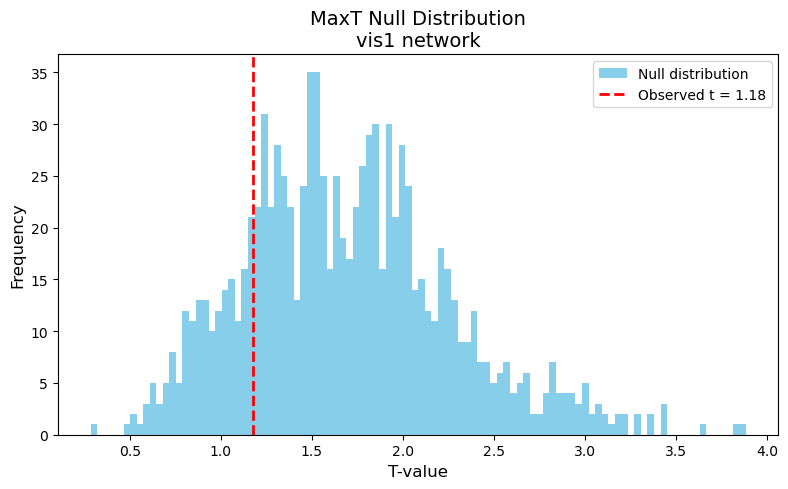

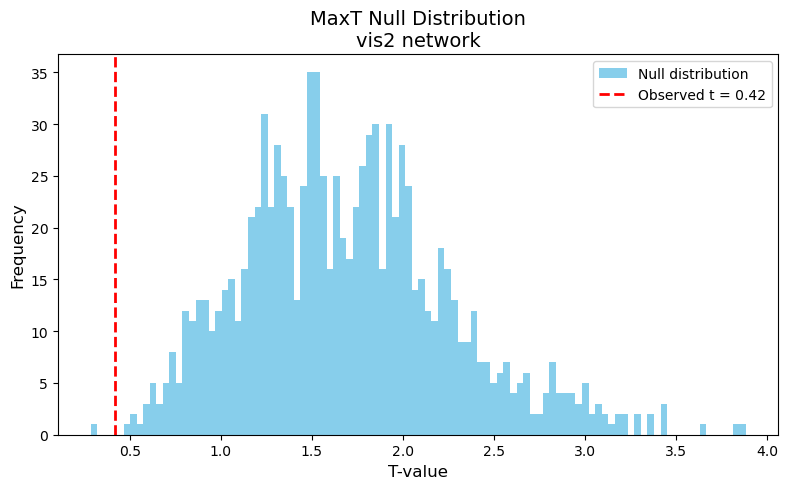

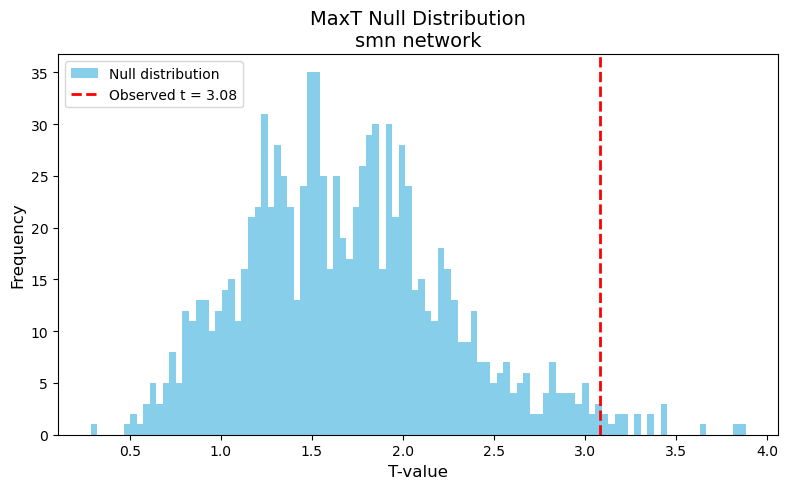

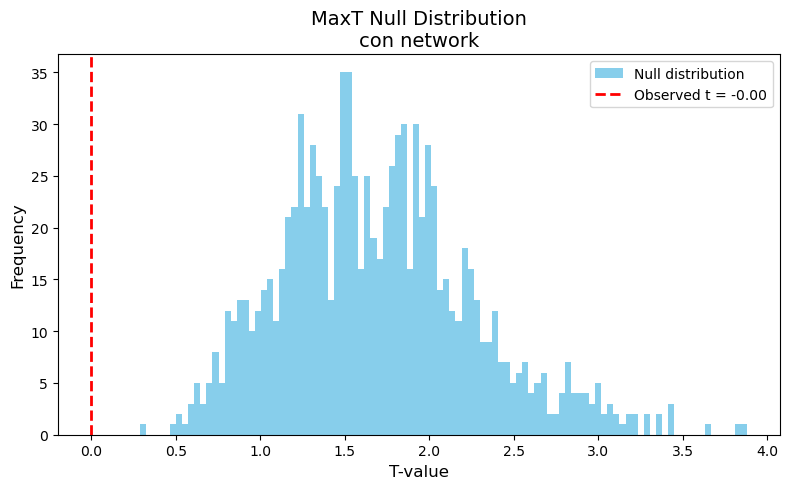

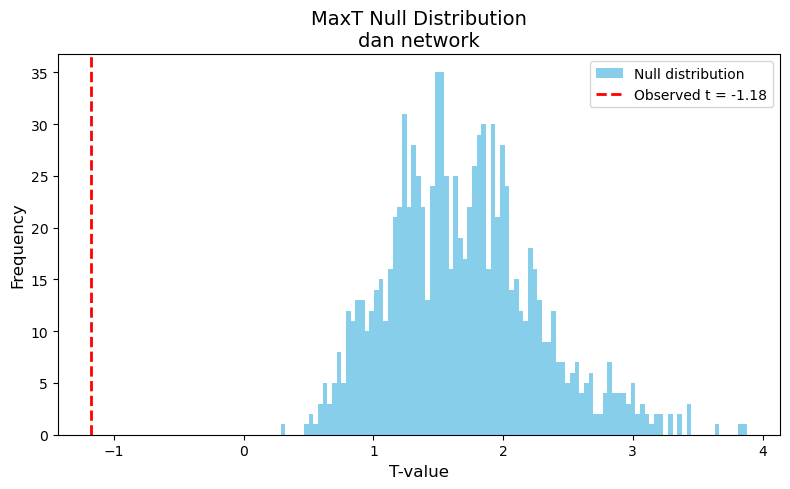

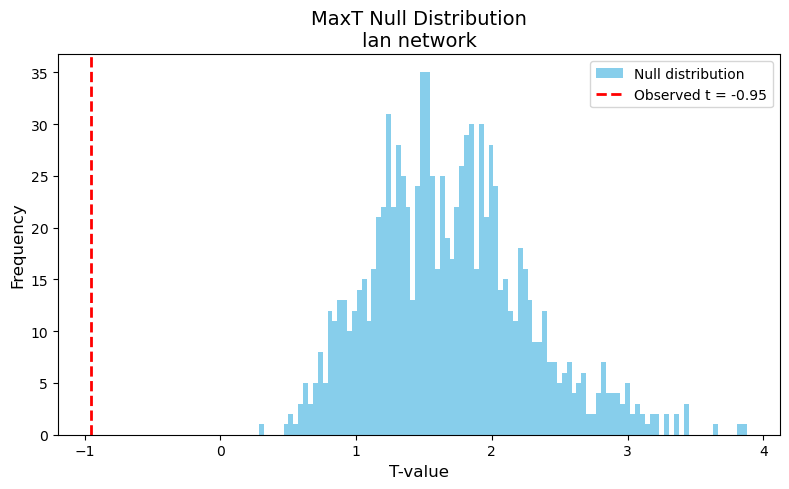

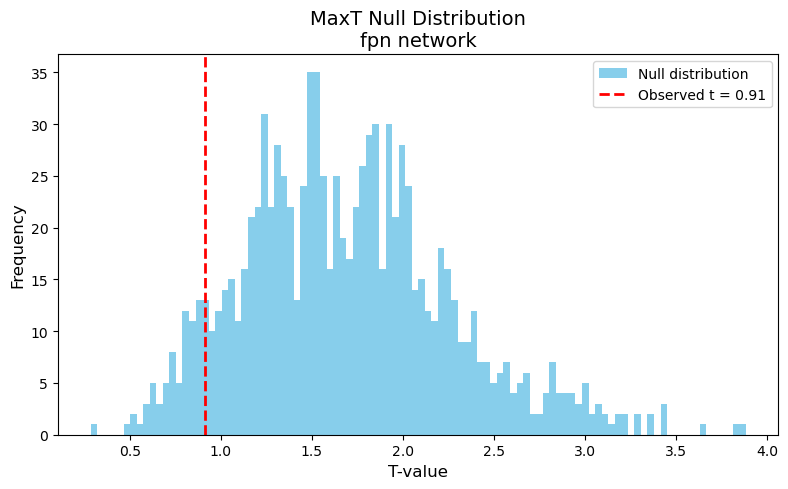

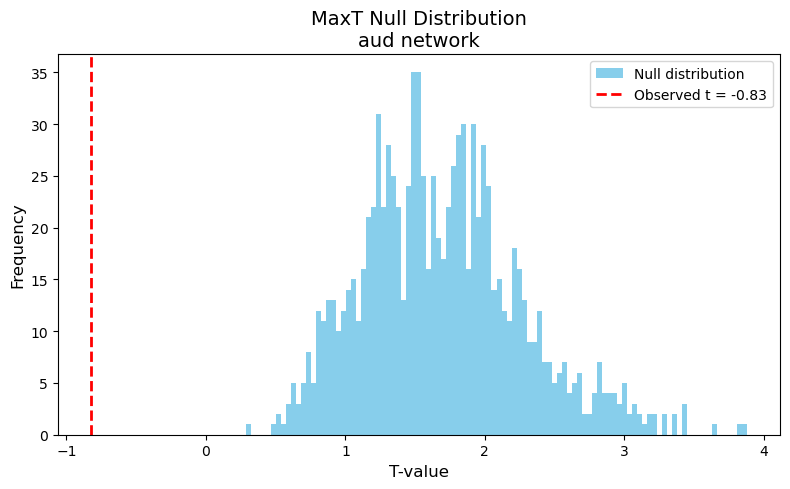

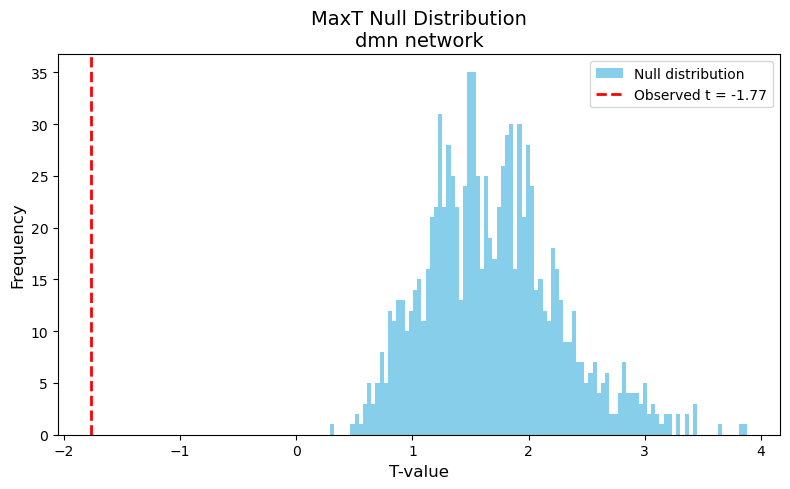

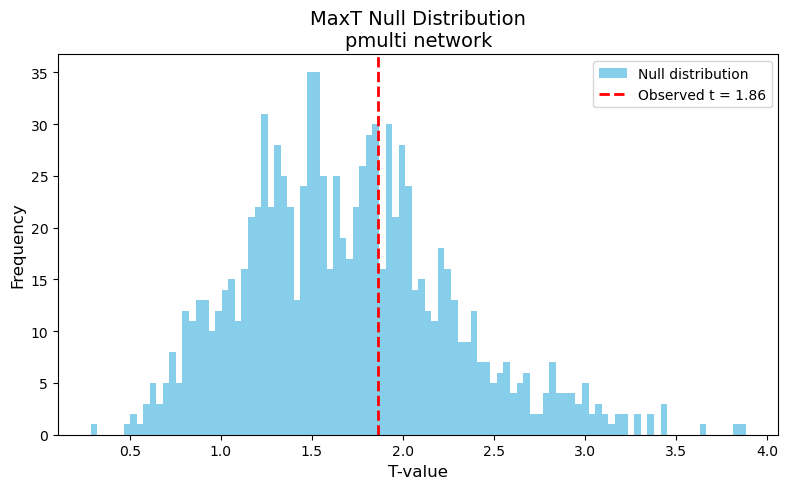

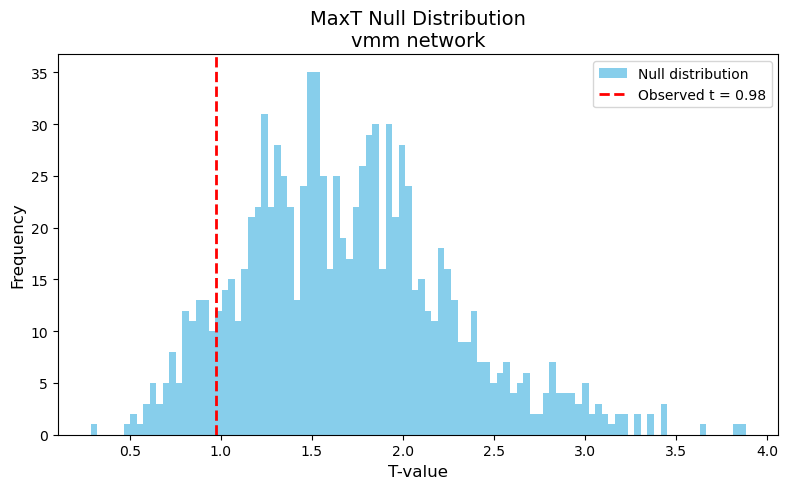

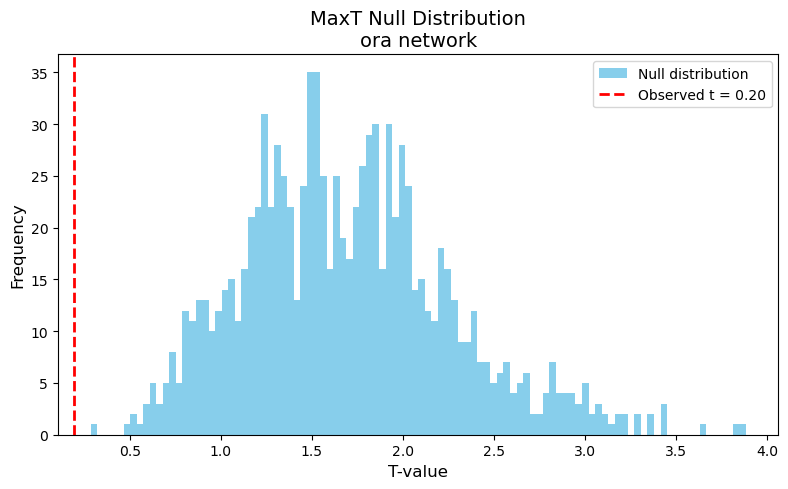

In [28]:
for i in range(12):
    network_index = i
    network_name = list(networkmappings.keys())[network_index]
    actual_t = t_obs[network_index]
    plot_null_with_observed(maxT_dist, actual_t, network_name)